Preprocessing audio data seems extremely important and is not obvious.


In this notebook I will generate 3 different sets of spectograms that we will be able to train on. Last but not least, we will use 3 spectograms to generate an image (storing them in the 3 channels).

Before we jump to this, it would be good to pinpoint the information that would be worthwhile to visualize.

In [1]:
from pathlib import Path
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastprogress import progress_bar
import librosa.display
from scipy.io import wavfile
from scipy.ndimage import center_of_mass
import PIL

In [7]:
trn_paths = list(Path('data/audio_train/').iterdir())
tst_paths = list(Path('data/audio_test/').iterdir())

In [3]:
%%time

trn_srs = []
trn_lengths = []
max_vals = []

for path in Path('data/audio_train').iterdir():
    x, sr = librosa.core.load(path, sr=None)
    trn_srs.append(sr)
    trn_lengths.append(x.shape[0] / sr)
    max_vals.append(np.max(x))

CPU times: user 3.86 s, sys: 1.46 s, total: 5.33 s
Wall time: 5.34 s


In [4]:
np.quantile(trn_lengths, 0.15), np.quantile(trn_lengths, 0.31), np.quantile(trn_lengths, 0.56), np.quantile(trn_lengths, 0.75)

(1.02, 2.0, 5.0, 9.38)

15% of data is under 1 second long, 31% under 2 seconds. These numbers are maybe not that telling as there is some silence in some of the files.

I manually inspected the files and it does not seem that removing silence is the way to go. It's hard to pick a hyperapameter (`top_db`) that will perform well across different recordings.

But maybe we don't have to go this route at all. Let's identify the meaningful portions in audio files and try to zone in on those.

In [5]:
from scipy.ndimage.measurements import center_of_mass

In [6]:
SR = 22050

def zone_in(path, length=2):
    # length given in seconds
    
    x, sr = librosa.core.load(path, sr=SR)
    if np.count_nonzero(x) == 0: # accomodation for the corrupted files in test, otherwise we get an error
        x = np.zeros(length*SR) 
    else:
        center_idx = int(center_of_mass(x)[0])
        half_of_length = length*sr//2 # measured in samples
        if center_idx < half_of_length:
            x = x[:length*sr]
        else:
            x = x[center_idx-half_of_length:center_idx+half_of_length]

    return np.pad(x, (0, length*SR))[:length*SR]

In [7]:
x, sr = librosa.load(trn_paths[3581], sr=SR)
Audio(x, rate=sr)

In [8]:
x = zone_in(trn_paths[3581])
Audio(x, rate=sr)

Seems to work!

In [9]:
dir_name = '22k_2sec_centered'

!rm -rf data/audio_train_{dir_name}
!rm -rf data/audio_test_{dir_name}

!mkdir data/audio_train_{dir_name}
!mkdir data/audio_test_{dir_name}

In [10]:
def zone_in_and_save(path, save_to):
    x = zone_in(path)
    librosa.output.write_wav(f'{save_to}/{path.name}', x, SR, norm=False)

In [11]:
def process_train(path): zone_in_and_save(path, f'data/audio_train_{dir_name}')
def process_test(path): zone_in_and_save(path, f'data/audio_test_{dir_name}')

In [12]:
parallel(process_train, trn_paths, n_workers=6) # use worker count == num physical CPU cores because of https://stackoverflow.com/a/54756707

(#9473) [None,None,None,None,None,None,None,None,None,None...]

In [13]:
parallel(process_test, tst_paths, n_workers=6)

(#9400) [None,None,None,None,None,None,None,None,None,None...]

This preprocessing is okay, but think about the produced spectorgrams for files under 2 seconds of length and under 4 seconds of length. This situation is further exacerbated when we consider that many of the files have a lot of silence or very quiet sounds.

For a file that is under 2 seconds long, two unfortunate things will happen.

1. There will be a large portion of the spectogram that will contain no information (wasted computation).
2. The most interesting part is likely to appear off-center. In the case of very short files, it is bound to exist all the way to the left of the spectogram. This is very bad news.

Point #2 is particularly important. Because of how the receptive field works, anything that is to the side in an image will receive much less scrutiny from the model than what appears in the center.

Wasting computation and not utilizing the capabitilites of our model is bound to hamper our results.

I would like to generate another dataset where before finding the center of mass we prepend and append the file with an empty sequence. This way we still get a lot of surface area that we are not using that we could use to encode some information, but at least the most important information appears in the center.

Another way this idea could evolve would be to mirror or repeat the sequence in some other way should the file be too short. This is likely to only give marginal benefits and would come at a price of increasing complexity of the solution.

Let's stick to framing the information in the center for now.

In [3]:
SR = 22050

def zone_in_center(path, length=2):
    # length given in seconds
    
    x, sr = librosa.core.load(path, sr=SR)
    if np.count_nonzero(x) == 0: # accomodation for the corrupted files in test, otherwise we get an error
        x = np.zeros(length*SR) 
    else:
        x = np.concatenate((np.zeros(length*SR), x, np.zeros(length*SR) )) # <- padding on the left and right of the signal
        center_idx = int(center_of_mass(x)[0])
        half_of_length = length*sr//2 # measured in samples
        if center_idx < half_of_length:
            x = x[:length*sr]
        else:
            x = x[center_idx-half_of_length:center_idx+half_of_length]

    return x

In [4]:
def zone_in_and_save(path, save_to):
    x = zone_in_center(path)
    librosa.output.write_wav(f'{save_to}/{path.name}', x, SR, norm=False)

In [5]:
def process_train(path): zone_in_and_save(path, f'data/audio_train_{dir_name}')
def process_test(path): zone_in_and_save(path, f'data/audio_test_{dir_name}')

In [6]:
dir_name = '22k_2sec_better_centered'

!rm -rf data/audio_train_{dir_name}
!rm -rf data/audio_test_{dir_name}

!mkdir data/audio_train_{dir_name}
!mkdir data/audio_test_{dir_name}

In [7]:
parallel(process_train, trn_paths, n_workers=4) # use n_workers < physical CPU count

(#9473) [None,None,None,None,None,None,None,None,None,None...]

In [8]:
parallel(process_test, tst_paths, n_workers=4)

(#9400) [None,None,None,None,None,None,None,None,None,None...]

There is still a lot of data that we could salvage for training. For our intents and purposes, this should be a good enough approach - we will find out when we train our first model.

## Generating spectograms

I would like to build a model where audio is transformed on the fly into spectograms using [torchaudio](https://github.com/pytorch/audio).

First of all though, I will train a couple of models on spectograms saved as images. I want to get a feel for how much of a burden it is to perform the transformation on the fly, and for that having a baseline is a good idea. Also, one method of the methods of generating spectograms that I want to try, [the linear reassignment](https://github.com/earthspecies/spectral_hyperresolution), will most likely be too expensive at the moment to perform on the fly.

In [2]:
trn_paths = list(Path('data/audio_train_22k_2sec_better_centered/').iterdir())
tst_paths = list(Path('data/audio_test_22k_2sec_better_centered/').iterdir())

In [3]:
x, sr = librosa.load(trn_paths[1])

In [4]:
hop_length = 512
n_fft = 2048
S = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)

Here are the three spectograms we will generate

/home/radek/.local/lib/python3.7/site-packages/librosa/display.py:725: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn('Trying to display complex-valued input. '


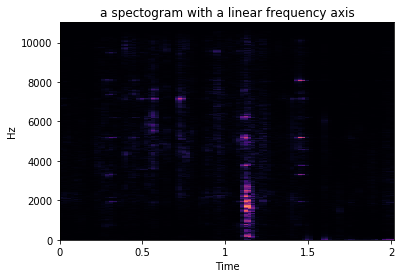

In [5]:
ax = librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='linear')
plt.title('a spectogram with a linear frequency axis');

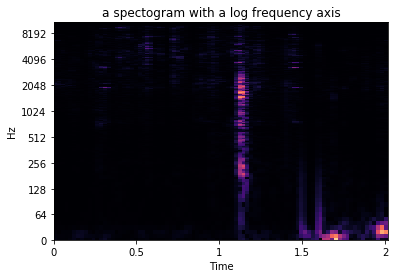

In [6]:
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='log')
plt.title('a spectogram with a log frequency axis');

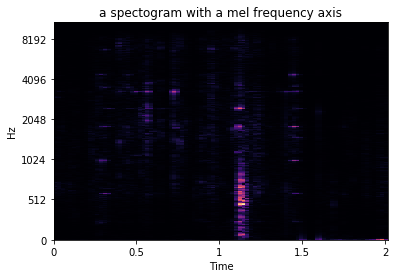

In [13]:
ax = librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')
plt.title('a spectogram with a mel frequency axis');

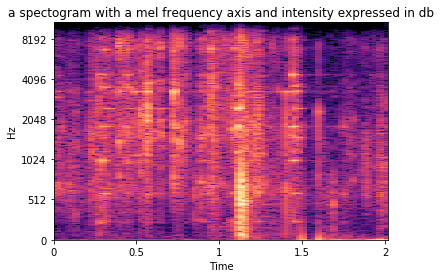

In [14]:
S_db = librosa.amplitude_to_db(abs(S))
ax = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
plt.title('a spectogram with a mel frequency axis and intensity expressed in db');

In [15]:
dir_name = '22k_2sec_better_centered'

trn_paths = list(Path(f'data/audio_train_{dir_name}/').iterdir())
tst_paths = list(Path(f'data/audio_test_{dir_name}/').iterdir())

In [13]:
sz = 224

def save_spectogram(path, save_to, y_axis='linear', loudness='linear'):
    hop_length = 512
    n_fft = 2048
    
    fig = plt.figure(figsize=[0.72, 0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    
    x, sr = librosa.load(path)
    S = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)
    if loudness == 'db': S = librosa.amplitude_to_db(abs(S))
    ax = librosa.display.specshow(S, sr=sr, x_axis='time', y_axis=y_axis)    
    ax.figure.savefig(f'{save_to}/{path.stem}.png', dpi=400, bbox_inches='tight', pad_inches=0)
    plt.close('all')
    
    # saving, loading, resizing and saving strikes me as inefficient / could be losing quality
    # but I don't think this is the time to keep figuring out how else to do this
    im = PIL.Image.open(f'{save_to}/{path.stem}.png')
    im.resize((sz,sz), resample=PIL.Image.BICUBIC).save(f'{save_to}/{path.stem}.png')

In [16]:
y_axis_and_loudness_options = [
    ['linear', 'linear', 'log', 'log', 'mel', 'mel'],
    ['linear', 'db', 'linear', 'db', 'linear', 'db']
]

for y_axis, loudness in zip(*y_axis_and_loudness_options):
    !rm -rf data/img_train_{dir_name}_{y_axis}_{loudness}
    !rm -rf data/img_test_{dir_name}_{y_axis}_{loudness}

    !mkdir data/img_train_{dir_name}_{y_axis}_{loudness}
    !mkdir data/img_test_{dir_name}_{y_axis}_{loudness}

    def process_train(path): save_spectogram(path, f'data/img_train_{dir_name}_{y_axis}_{loudness}', y_axis, loudness)
    def process_test(path): save_spectogram(path, f'data/img_test_{dir_name}_{y_axis}_{loudness}', y_axis, loudness)
    
    break    
    
    for path in progress_bar(trn_paths): process_train(path)
    for path in progress_bar(tst_paths): process_test(path)

In [17]:
from linear_reassignment import *

In [24]:
sz = 224

def save_spectogram(path, save_to):
    tdeci = 512
    over = 4
    noct = 12
    minf = 1e-3
    maxf = 0.5
    x, sr = librosa.load(path)
    spectogram = create_reassigned_representation(x.reshape(-1, 1), q, tdeci, over, noct, minf, maxf)
    
    spectogram_dense = spectogram.todense().T
    minfreq = minf*sr
    maxfreq = maxf*sr
    
    fig = plt.figure(figsize=[0.72, 0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    ax.matshow(spectogram_dense, cmap=cm.gray_r)
    ax.figure.savefig(f'{save_to}/{path.stem}.png', dpi=400, bbox_inches='tight', pad_inches=0)
    plt.close('all')
    
    # saving, loading, resizing and saving strikes me as inefficient / could be losing quality
    # but I don't think this is the time to keep figuring out how else to do this
    im = PIL.Image.open(f'{save_to}/{path.stem}.png')
    im.resize((sz,sz), resample=PIL.Image.BICUBIC).save(f'{save_to}/{path.stem}.png')

In [25]:
dir_name = '22k_2sec_better_centered'

In [26]:
for q in [1]:
    !rm -rf data/img_train_{dir_name}_{q}
    !rm -rf data/img_test_{dir_name}_{q}

    !mkdir data/img_train_{dir_name}_{q}
    !mkdir data/img_test_{dir_name}_{q}
    
    def process_train(path): save_spectogram(path, f'data/img_train_{dir_name}_{q}')
    def process_test(path): save_spectogram(path, f'data/img_test_{dir_name}_{q}')
    
    for path in progress_bar(trn_paths): process_train(path)
    for path in progress_bar(tst_paths): process_test(path)

ValueError: invalid number of data points ([0 1]) specified